# オプション価格

### オプション価格を求めるには

* 原資産価格
* 権利行使価格
* 満期までの期間
* 価格を算出するためのモデル

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import ivolat3

In [2]:
np.random.seed(1)
s_df = pd.read_pickle("./data/s.pickle")
op_pn = pd.read_pickle("./data/op1.pickle")
t0 = pd.to_datetime("2018-02-26 15:15")
t1 = pd.to_datetime("2018-03-09 09:00")
s0 = s_df.loc[t0, "1803"]
r = 0.001
delta_t = t1 - t0
t = (delta_t.days / 365) + (delta_t.seconds / 31536000)
op_df = op_pn.loc["2018-02-26 15:15"].dropna().copy()
op_df["k"] = op_df.index
delta_call = op_df.apply(
    lambda x: ivolat3.delta(s0, x["k"], r, 0, t, x["iv"], "C"), axis=1
)

delta_call = pd.Series(delta_call.values, index=op_df["k"])
k = delta_call.map(lambda x: abs(x - 0.25)).idxmin()
price, sigma = op_df.loc[k, ["price", "iv"]]

### 2018年02月26日のコールオプション

In [3]:
print("原資産価格: {}".format(s0))
print("権利行使価格: {}".format(k))
print("満期までの期間: {:.2f}年({:.2f}日)".format(t, t * 365))
print("プレミアム: {:.2f}".format(price))
print("ボラティリティ: {:.2f}%".format(sigma * 100))

原資産価格: 22214.1
権利行使価格: 22625.0
満期までの期間: 0.03年(10.74日)
プレミアム: 108.20
ボラティリティ: 17.22%


### 幾何ブラウン運動

> 「[幾何ブラウン運動](https://ja.wikipedia.org/wiki/幾何ブラウン運動)」（2017年3月2日 (木) 04:18　UTCの版）『ウィキペディア日本語版』。

$dS_t = \mu S_t\,dt + \sigma S_t\,dB_t$

$S_t = S_0\exp\left( \left(\mu - \frac{\sigma^2}{2} \right)t + \sigma B_t\right),$

$s_0 = 22214.1$  
$\mu = 0$  
$sigma = 0.1722$  
$t = 0.03$

幾何ブラウン運動に従う乱数を用いて$S_t$を算出

```python
def get_st(s0, mu, sigma, t):
    return s0 * np.exp(
        np.random.normal(
            (mu - 0.5 * sigma ** 2) * t, sigma * np.sqrt(t))
    )
```

```python
>>> get_st(s0, 0, sigma, t)
23295.801603657848
>>> get_st(s0, 0, sigma, t)
21806.759778023705
>>> get_st(s0, 0, sigma, t)
21860.668118808022
```

In [4]:
def get_st(s0, mu, sigma, t):
    return s0 * np.exp(
        np.random.normal(
            (mu - 0.5 * sigma ** 2) * t, sigma * np.sqrt(t))
    )

In [5]:
get_st(s0, 0, sigma, t)

23295.801603657848

In [6]:
get_st(s0, 0, sigma, t)

21806.759778023705

In [7]:
get_st(s0, 0, sigma, t)

21860.668118808022

In [8]:
get_st(s0, 0, sigma, t)

21511.680390211179

上記を10000回繰り返した結果のヒストグラム

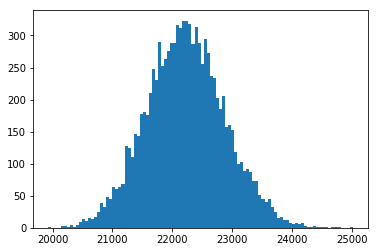

In [9]:
st = np.array([get_st(s0, 0, sigma, t) for _ in range(10000)])

fig, ax = plt.subplots()
ax.hist(st, bins=100);

$k = 22625$を超えた価格がITMとなる

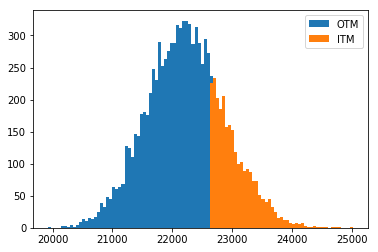

In [10]:
itm = st[st - k > 0]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(st, range=(st.min(), st.max()), bins=100, label="OTM");
ax.hist(itm, range=(st.min(), st.max()), bins=100, label="ITM");
plt.legend()
plt.show()

権利行使価格$k$で得られる損益は$s_t - k$または0の最大値をとる

$max(s_t - k, 0)$

In [11]:
payoff = [max(s - k, 0) for s in st]

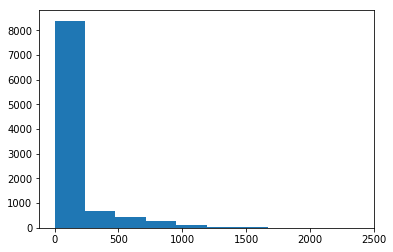

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
_ = ax.hist(payoff)
plt.show()

この差分の平均を算出するとコールオプションの価格となる

In [13]:
np.mean([max(s - k, 0) for s in st])

109.49959424558575

* 乱数を発生させるにはコンピュータを用いないといけない
* 十分なサンプルを得るには数万回サイコロを振らないといけない -> 手が疲れる

### ブラックショールズ方程式

> 「[ブラック–ショールズ方程式](https://ja.wikipedia.org/wiki/ブラック–ショールズ方程式)」（2016年10月10日 (月) 15:39 　UTCの版）『ウィキペディア日本語版』。

下記の式を用いるとコールオプションの価格が一発で求められる

$C(S_t, t) = S_t N(d_1) - Ke^{-r(T-t)} N(d_2)$

プットオプションの価格はプットコールパリティから求められる

$N(d)$は確率密度関数と呼ばれ、先に試行した分布(ヒストグラム)の色が変わった部分を求められる

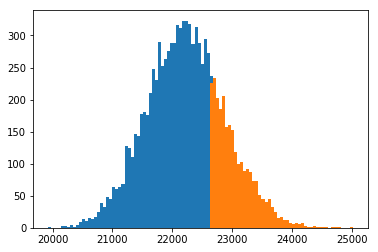

In [14]:
_ = plt.hist(st, range=(st.min(), st.max()), bins=100, label="OTM")
_ = plt.hist(itm, range=(st.min(), st.max()), bins=100, label="ITM")

```python
def d1(S0, k, r, sigma, t):
    return (np.log(S0 / k) + (r + sigma ** 2 / 2) * t) / (sigma * np.sqrt(t))


def d2(S0, K, r, sigma, t):
    return (np.log(S0 / k) + (r - sigma ** 2 / 2) * t) / (sigma * np.sqrt(t))


def bs_call(S0, k, r, sigma, t):
    return S0 * stats.norm.cdf(d1(S0, k, r, sigma, t)) - k * np.exp(
        -r * t
    ) * stats.norm.cdf(d2(S0, k, r, sigma, t))
```

```python
>> bs_call(s0, k, r, sigma, t)
108.19777523292942
```

In [15]:
def d1(S0, k, r, sigma, t):
    return (np.log(S0 / k) + (r + sigma ** 2 / 2) * t) / (sigma * np.sqrt(t))


def d2(S0, K, r, sigma, t):
    return (np.log(S0 / k) + (r - sigma ** 2 / 2) * t) / (sigma * np.sqrt(t))


def bs_call(S0, k, r, sigma, t):
    return S0 * stats.norm.cdf(d1(S0, k, r, sigma, t)) - k * np.exp(
        -r * t
    ) * stats.norm.cdf(d2(S0, k, r, sigma, t))

In [16]:
bs_call(s0, k, r, sigma, t)

108.19777523292942

### インプライド・ボラティリティ

* これまではボラティリティからオプションのプレミアムを算出していたが、オプションのプレミアムからボラティリティを逆算できる
* プレミアムからボラティリティを求める式は存在しないため、ボラティリティの値を試行錯誤してプレミアムと等価になるまで繰り返し演算する
* 結局はコンピュータが必要になる

### グリークス

ブラックショールズの式から偏微分して求められる

#### デルタ
$$ \Delta := \frac{\partial C}{\partial S_t} = N(d_1) $$

#### ガンマ
$$ \Gamma := \frac{\partial^2 C}{\partial S_t^2} = \dfrac{1}{\sigma S_t\sqrt{T-t}}\frac{1}{\sqrt{2\pi}}\mathrm{exp}\left\{-\frac{1}{2}d_1^2\right\} $$

#### ベガ
$$ \kappa := \frac{\partial C}{\partial \sigma} = S_t\sqrt{T-t}\frac{1}{\sqrt{2\pi}}\mathrm{exp}\left\{-\frac{1}{2}d_1^2\right\} $$


#### セータ
$$ \Theta := \frac{\partial C}{\partial t} = - rKe^{-r(T-t)}N(d_2) - \dfrac{\sigma S_t}{2\sqrt{T-t}}\frac{1}{\sqrt{2\pi}}\mathrm{exp}\left\{-\frac{1}{2}d_1^2\right\} $$

### モデルの課題

* 原資産価格の価格が幾何ブラウン運動(対数正規分布)に従う前提となっている  
  実際の分布はどうなのか？ -> いくつかの分布が提案されているが真の分布は誰もわからない
* 実際のオプション価格は満期までの期間や権利行使価格によってばらつきがでる
* 権利行使価格がATMから離れるほどボラティリティが変化する  
  この曲線をボラティリティスマイルまたはボラティリティサーフェイサーと呼ばれる